## What you Will Learn in this Notebook

## Table of Contents

- [Data Generating Process](#Data-Generating-Process)
- [Define Sampling Functions](#Define-Sampling-Functions)
- [Expert Forecasts](#Expert-Forecasts)
- [Converting Forecasting Problem into a Regression One](#Converting-Forecasting-Problem-into-a-Regression-One)
- [Building Regression Models With Customized Loss From Scratch](#Building-Regression-Models-With-Customized-Loss-From-Scratch)
- [Further Notes on Fitting a Model on MAPE](#Further-Notes-on-Fitting-a-Model-on-MAPE)

In [1]:
import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import uniform #, norm, chi2, ncx2, pareto

In [2]:
import os
import sys

#parent_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

sys.path.append(parent_dir)

import utilityFuncs as uf

import utilityClasses as uc


<a name="Data-Generating-Process"></a>
## Data Generating Process

Your introduction content goes here.




Imagine that the Data Generating Process (DGP) is based on a Gaussian GARCH(1, 1):


$$Z_t \sim \mathcal{N}(0,\,\sigma_{t}^{2})\,.$$
$$\sigma_{t} = a_0 Z_{t-1}^{2} + a_1 \sigma_{t-1}^{2} + a_2$$


and the target variable (i.e., variable to be forecasted) $Y_t$ simply follows

$$Y_t = \mu + Z_t^2$$

Let's code the above DGP.

In [3]:
NUM_DAYS = 183
TEST_INDEX = 153
INITIAL_SIGMA = 1
INITIAL_Z = 0

ALL_DAYS = [day for day in range(0, NUM_DAYS)]
TEST_DAYS = [day for day in range(TEST_INDEX, NUM_DAYS)]

In [4]:
z_values, sigma_values, days_simulated = uf.simulate_variable_evolution(NUM_DAYS, INITIAL_SIGMA, INITIAL_Z)

In [5]:
MU = 1
y_values = [MU + elem**2 for elem in z_values]

Create a dataframe to save days and actual values

In [6]:
df_actual_values = pd.DataFrame({'days': days_simulated, 'actual_values':y_values}, columns=['days','actual_values'])
df_actual_values.to_csv('Data/df_actual_values.csv', sep='\t', float_format='%.4f')


<a name="Define-Sampling-Functions"></a>
## Define Sampling Functions

In [7]:
n = 100000
Y_scale = 10

def pdf_expression(mean, std, x):
    "See notebook Transformations.ipynb"
    return (1. / (1. * std * np.sqrt(2. * np.pi * (x - mean)))) * np.exp(-(x - mean) / (2. * std ** 2.))


def Y_pdf(mean, std):
    return lambda x: pdf_expression(mean, std, x)


def Y_aux_pdf(mean, std):
    return lambda x: pdf_expression(mean, std, x) / x

<a name="Expert-Forecasts"></a>
## Expert Forecasts

As discussed in the videos, expert forecasts are either mean, median of the underlying distribution or the median of the auxiliary variable $Y_2$.

In [8]:
# Forecasts
# [TEST_INDEX:]
means = [MU + elem**2 for elem in sigma_values]
medians = [MU + 0.4549*elem**2 for elem in sigma_values]

minusOneMedians = [np.median(uf.importance_sampling(Y_aux_pdf(MU, elem), \
                                                     uniform(loc=MU, scale=Y_scale), n)[0]) \
                                                     for elem in sigma_values]

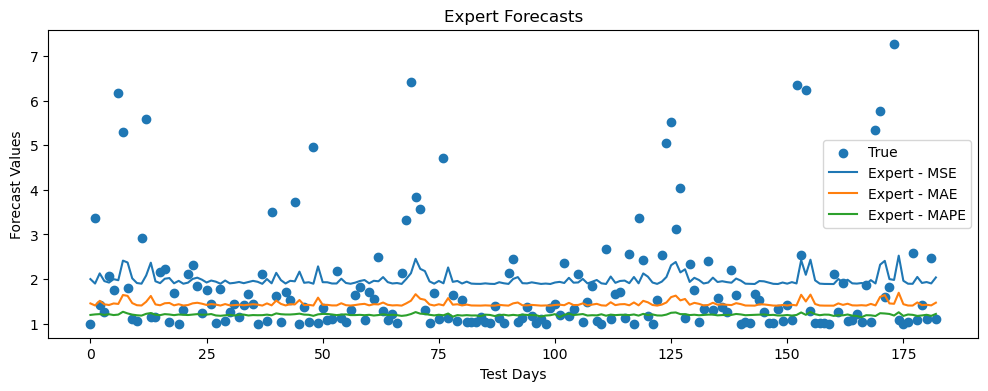

In [9]:
plt.figure(figsize=(12, 4))
plt.scatter(ALL_DAYS, y_values, label='True')
plt.plot(ALL_DAYS, means, label='Expert - MSE')
plt.plot(ALL_DAYS, medians, label='Expert - MAE')
plt.plot(ALL_DAYS, minusOneMedians, label='Expert - MAPE')

plt.xlabel('Test Days')
plt.ylabel('Forecast Values')
plt.title('Expert Forecasts')

plt.legend()
plt.show()

<a name="Converting-Forecasting-Problem-into-a-Regression-One"></a>
## Converting Forecasting Problem into a Regression One

In [10]:
sliding_width = 1
n_steps_in = 3
#n_steps_out = 1
n_steps_out = 1
series_length = len(y_values)
n_features = 2

features_train_validation = np.empty((series_length, n_features))
features_train_validation[:] = np.NaN

In [11]:
map_feature_nums_to_clmn_lbl = {
                          '0': 'actual_values',
                          '1':'days'}

In [12]:
for i in range(n_features):
    #features_train_validation[:,i] = df_actual_values.loc[0:TEST_INDEX - 1, map_feature_nums_to_clmn_lbl[str(i)]]
    features_train_validation[:,i] = df_actual_values.loc[0:, map_feature_nums_to_clmn_lbl[str(i)]]

In [13]:
use_future_vals_in_pair_cnstruction = [False, False]

In [14]:
dataset = uf.prepare_data_for_mapping_func(features_train_validation, \
                                           use_future_vals_in_pair_cnstruction, \
                                           series_length, \
                                           n_features, n_steps_in, n_steps_out)
FeaturesArray, TargetsArray = uf.map_forecasting_to_supervised(dataset, n_steps_in, n_steps_out, sliding_width)


In [15]:
FeaturesArray.shape

(180, 3, 2)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(FeaturesArray, TargetsArray, test_size=1 - TEST_INDEX/len(ALL_DAYS), random_state=42)

<a name="Building-Regression-Models-With-Customized-Loss-From-Scratch"></a>
## Building Regression Models With Customized Loss From Scratch

We want to build regression models trained on losses other than MSE (ex. MAE and MAPE). However, scikit learn allows using only MSE for training:

- https://github.com/scikit-learn/scikit-learn/issues/1701
- https://stackoverflow.com/questions/49493331/random-forest-regressor-using-a-custom-objective-loss-function-python-sklearn

So we need to implement training such models from "scratch" (i.e., relying on scipy optimize only). 

In [17]:
regularization = 0.01
coefficients_init = np.random.normal(0, 1, [X_train.shape[1]*X_train.shape[2], y_train.shape[1]])

In [18]:
coefficients_init

array([[-0.6916292 ],
       [ 0.10490928],
       [-0.94075518],
       [ 0.96680737],
       [ 0.59958092],
       [-1.68389652]])

In [19]:
n_steps_in, n_steps_out, n_features

(3, 1, 2)

In [20]:
coefficients_init.shape

(6, 1)

In [21]:
bounds_DE = [(-100, 100)] * coefficients_init.flatten().shape[0]

In [22]:
MAPE_Model = uc.LinearModelWithCustomLoss(
    loss_function=mean_absolute_percentage_error,
    X=X_train, Y=y_train,
    coefficients_init=coefficients_init,
    regularization=regularization,
    bounds=bounds_DE, 
    optimizer='DE',
    max_iterations=1000, tol=0.001,
    verboose=True
)
MAPE_Model.fit()
print(MAPE_Model.coefficients)

differential_evolution step 1: f(x)= 18.0617
differential_evolution step 2: f(x)= 12.2784
differential_evolution step 3: f(x)= 12.2784
differential_evolution step 4: f(x)= 7.81979
differential_evolution step 5: f(x)= 4.34199
differential_evolution step 6: f(x)= 4.13257
differential_evolution step 7: f(x)= 4.13257
differential_evolution step 8: f(x)= 4.13257
differential_evolution step 9: f(x)= 4.13257
differential_evolution step 10: f(x)= 4.13257
counter =  10 , loss 0.9934699403894783
differential_evolution step 11: f(x)= 4.13257
differential_evolution step 12: f(x)= 4.13257
differential_evolution step 13: f(x)= 3.81201
differential_evolution step 14: f(x)= 3.81201
differential_evolution step 15: f(x)= 3.81201
differential_evolution step 16: f(x)= 3.81201
differential_evolution step 17: f(x)= 3.81201
differential_evolution step 18: f(x)= 3.81201
differential_evolution step 19: f(x)= 3.27143
differential_evolution step 20: f(x)= 3.27143
counter =  20 , loss 1.0347652892625308
different

In [23]:
mape_pred = MAPE_Model.predict(X_train)
mape_forecast = MAPE_Model.predict(X_test)

In [24]:
mape_forecast

array([[1.1368208 ],
       [1.17060766],
       [1.51625937],
       [1.10432038],
       [1.08561065],
       [1.20536058],
       [1.1667051 ],
       [1.56952917],
       [1.14873671],
       [1.21242328],
       [1.12265224],
       [1.17469999],
       [1.36898236],
       [1.14348081],
       [1.12806311],
       [1.11533975],
       [1.11749396],
       [1.30381992],
       [1.0987906 ],
       [1.15774869],
       [1.09390546],
       [1.09266627],
       [1.13223193],
       [1.13759054],
       [1.12632673],
       [1.59269341],
       [1.1569248 ],
       [1.10699866],
       [1.0921057 ],
       [1.10957155]])

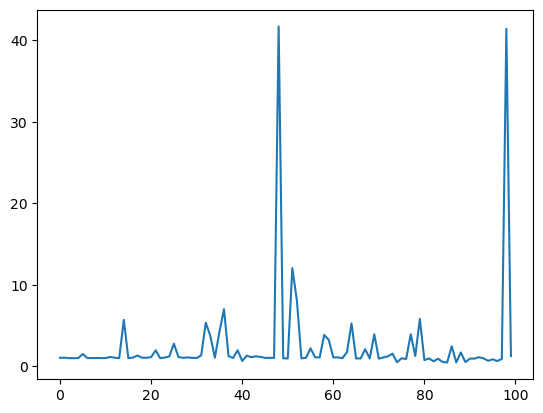

In [25]:
plt.plot(MAPE_Model.loss_values, label='MAPE')


In [26]:
X_test.shape, mape_forecast.shape

((30, 3, 2), (30, 1))

In [27]:
MSE_Model = uc.LinearModelWithCustomLoss(
    loss_function=mean_squared_error,
    X=X_train, Y=y_train, regularization=regularization, coefficients_init=coefficients_init
)
MSE_Model.fit()
print(MSE_Model.coefficients)
mse_pred = MSE_Model.predict(X_train)
mse_forecast = MSE_Model.predict(X_test)

[[ 0.00143498]
 [-0.5311336 ]
 [ 0.12797058]
 [-0.00073597]
 [ 0.21024842]
 [ 0.53378538]]


In [28]:
MAE_Model = uc.LinearModelWithCustomLoss(
    loss_function=mean_absolute_error,
    X=X_train, Y=y_train, regularization=regularization, coefficients_init=coefficients_init
)
MAE_Model.fit()
print(MAE_Model.coefficients)
mae_pred = MAE_Model.predict(X_train)
mae_forecast = MAE_Model.predict(X_test)

[[ 0.10638553]
 [-0.54931559]
 [ 0.02463755]
 [ 0.02637607]
 [ 0.09772705]
 [ 0.52196566]]


In [29]:
mae_forecast

array([[1.39715564],
       [1.61278693],
       [1.47014093],
       [1.3438697 ],
       [1.1871223 ],
       [1.44178143],
       [1.36485954],
       [1.88973693],
       [1.28782608],
       [1.48760529],
       [1.24742674],
       [1.1979696 ],
       [2.12749392],
       [1.23093231],
       [1.26802993],
       [1.48210677],
       [1.37602243],
       [2.00814527],
       [1.20890861],
       [1.37432401],
       [1.24928702],
       [1.25336265],
       [1.27057111],
       [1.32206849],
       [1.49007087],
       [1.38173859],
       [1.4754753 ],
       [1.385541  ],
       [1.23320995],
       [1.80037203]])

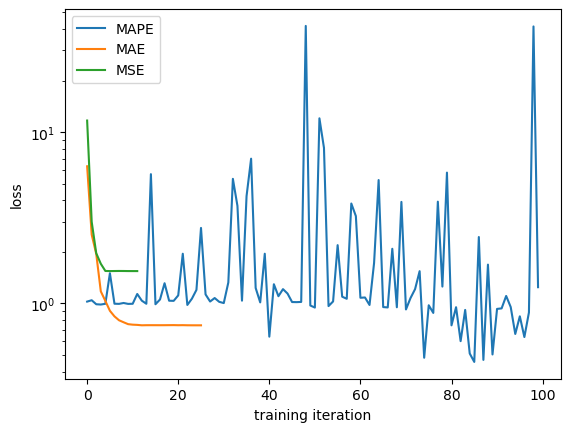

In [30]:
plt.plot(MAPE_Model.loss_values, label='MAPE')
plt.plot(MAE_Model.loss_values, label='MAE')
plt.plot(MSE_Model.loss_values, label='MSE')
plt.xlabel("training iteration")  
plt.ylabel("loss")  
plt.yscale("log")  
plt.legend()

In [31]:
mse_pred.shape, mse_pred.flatten().shape

((150, 1), (150,))

In [32]:
mse_forecast.shape, mse_forecast.flatten().shape

((30, 1), (30,))

In [33]:
mse_pred.shape, mse_forecast.shape

((150, 1), (30, 1))

Text(0.5, 0, 'Training Days')

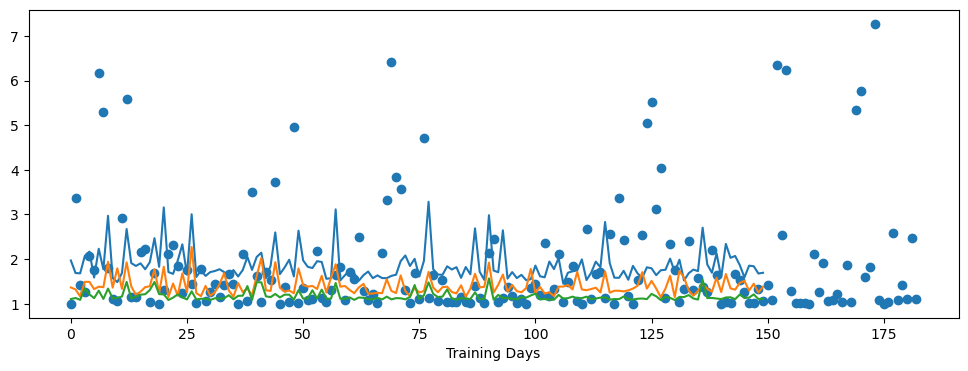

In [34]:
plt.figure(figsize=(12, 4))
plt.scatter(ALL_DAYS, y_values, label='True')

# plt.plot(ALL_DAYS[n_steps_in:TEST_INDEX], mse_pred, label='MSE - Train')
# plt.plot(ALL_DAYS[n_steps_in:TEST_INDEX], mae_pred, label='MAE - Train')
# plt.plot(ALL_DAYS[n_steps_in:TEST_INDEX], mape_pred, label='MAPE - Train')
# plt.plot(ALL_DAYS[TEST_INDEX:], mse_forecast.flatten(), label='MSE')
# plt.plot(ALL_DAYS[TEST_INDEX:], mae_forecast.flatten(), label='MAE')
# plt.plot(ALL_DAYS[TEST_INDEX:], mape_forecast.flatten(), label='MAPE')

# plt.xlabel('Training and Test Days')
# plt.ylabel('Forecast Values')
# plt.title('Forecasts of Linear Models Trained with Minimizing Different Loss Functions')
plt.plot(mse_pred, label='MSE - Train')
plt.plot(mae_pred, label='MAE - Train')
plt.plot(mape_pred, label='MAPE - Train')

plt.xlabel('Training Days')


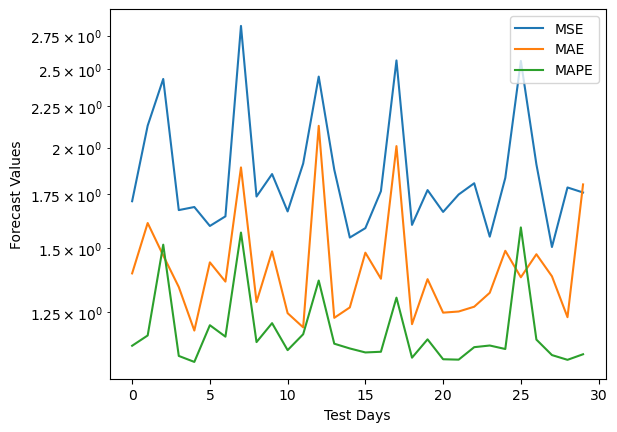

In [35]:


plt.plot(mse_forecast.flatten(), label='MSE')
plt.plot(mae_forecast.flatten(), label='MAE')
plt.plot(mape_forecast.flatten(), label='MAPE')

plt.xlabel('Test Days')
plt.ylabel('Forecast Values')

plt.legend()
plt.yscale("log")  

plt.show()


<a name="Further-Notes-on-Fitting-a-Model-on-MAPE"></a>
## Further Notes on Fitting a Model on MAPE


First derivative of MAPE with respect to $\hat{y}$ is not defined at $\hat{y} = y$ (because the derivative changes from $\frac{1}{Hy}$ to $\frac{-1}{Hy}$ as $\hat{y}$ goes from $y^+$ to $y^-$) so using it as the loss function to be minimized during training might create problems for gradient-based optimization methds. In addition, its second derivative (Hessian) is zero where it defined. 

To combat these potential problems, one can (#TORESEARCH)

- Use non-differentiable optimization methods: https://optimization.cbe.cornell.edu/index.php?title=Nondifferentiable_optimization
- Use a smoothing method to approximate MAPE differentially 
  - https://link.springer.com/article/10.1007/s13042-011-0031-2 
  - https://link.springer.com/chapter/10.1007/BFb0120696
  - https://ieeexplore.ieee.org/document/7844819/authors#authors
  - Use sub-gradient descent https://courses.cs.washington.edu/courses/cse546/15au/lectures/lecture10_sgd.pdf

Under what circumstances, training two models on a loss and scoring/ranking them on another loss can result in erroneous conclusions about their relative forecasting abilities? For example, between models A and B, A is acutally the better one but when they are trained on MSE and ranked with MAPE, B appears to be the better model. The answer is probably somehwere between "never" and "always"!(#TORESEARCH) 
